## Notebook 1: Exploring *Aedes aegypti* occurrence data
####  Student: Pedro Correia de Siracusa
####  Academic advisors: Artur Ziviani & Fábio Porto
--------

On this first notebook I'll perform some basic exploratory analysis on a publicly available scientific dataset on *Aedes aegypti* occurrence data, hosted by DRYAD Digital Repository (http://datadryad.org/resource/doi:10.5061/dryad.47v3c). This dataset was originally published by
>Kraemer MUG, Sinka ME, Duda KA, Mylne A, Shearer FM, Brady OJ, Messina JP, Barker CM, Moore CG, Carvalho RG, Coelho GE, Van Bortel W, Hendrickx G, Schaffner F, Wint GRW, Elyazar IRF, Teng H, Hay SI (2015) The global compendium of Aedes aegypti and Ae. albopictus occurrence. Scientific Data 2(7): 150035. http://dx.doi.org/10.1038/sdata.2015.35

Besides having a general overview of the available data, my goal with this exercise is to get more familiarized with some basic tools for performing data analysis with Python. Let's start by importing our main dataset into the environment. 

In [1]:
import urllib
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

% matplotlib inline
plt.rcParams['figure.figsize'] = (20, 10)

In [2]:
aegypti_data_url='http://datadryad.org/bitstream/handle/10255/dryad.88853/aegypti.csv?sequence=1'

try: 
    aegypti_dataset
    
except NameError:
    aegypti_dataset = pd.read_csv(aegypti_data_url)

## 1. Taking a first look

Let's take a quick look at this dataset:

In [3]:
print(aegypti_dataset[:3])

          VECTOR  OCCURRENCE_ID  SOURCE_TYPE LOCATION_TYPE POLYGON_ADMIN  \
0  Aedes aegypti              1  unpublished       polygon             2   
1  Aedes aegypti              2  unpublished       polygon             2   
2  Aedes aegypti              3  unpublished       polygon             2   

       Y      X  YEAR                   COUNTRY COUNTRY_ID  GAUL_AD0  STATUS  
0  25.49 -80.99  1960  United States of America        USA       259     NaN  
1  26.12 -81.33  1960  United States of America        USA       259     NaN  
2  26.13 -97.55  1960  United States of America        USA       259     NaN  


Next I list the top 5 countries with most occurrence records.  

In [4]:
records_by_country = aegypti_dataset.groupby('COUNTRY').size()
records_by_country.sort_values(ascending=False)[:5]

COUNTRY
Taiwan                      9501
Brazil                      5057
Indonesia                    606
Thailand                     500
United States of America     444
dtype: int64

As I'm mostly interested on the vector geographic range in Brazil (and fortunatelly there are plenty of records for it), let's work with that subset.

First I want to roughly visualize the availability and density of occurrence data for each Brazilian state. For that we're using *basemap* (http://matplotlib.org/basemap/), a library for plotting 2D data maps in Python. Some useful introductory examples on basemap:

* Plot points on a map: http://chrisalbon.com/python/matplotlib_plot_points_on_map.html
* Mapping Global Earthquake Activity: http://introtopython.org/visualization_earthquakes.html

Let's start by importing those libraries

In [5]:
import zipfile
from mpl_toolkits.basemap import Basemap

and subsetting the dataset

In [6]:
aegypti_dataset_br = aegypti_dataset[aegypti_dataset.COUNTRY=='Brazil']

Now I use some shapefiles from the *GADM database of Global Administrative Areas* (http://www.gadm.org/country) to add accurate information regarding Brazilian states boundaries.

In [7]:
br_adm_areas_url = 'http://biogeo.ucdavis.edu/data/gadm2.8/shp/BRA_adm_shp.zip'

try:
    temp_filename
    
except NameError:
    temp_filename, headers = urllib.request.urlretrieve(br_adm_areas_url)

archive = zipfile.ZipFile(temp_filename, 'r')
archive.extractall("./shapefiles")

and then build the map plotting occurrence data on it

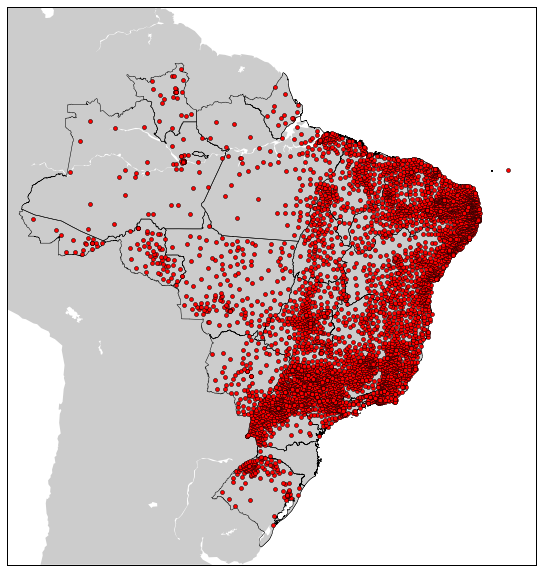

In [8]:
map = Basemap( projection='merc', 
                 llcrnrlat=-35, llcrnrlon=-75,
                 urcrnrlat=10, urcrnrlon=-30, 
                 lat_ts=20, resolution='l')

map.fillcontinents()

shp = map.readshapefile('./shapefiles/BRA_adm1', 'states', drawbounds=True)

aegypti_coords = aegypti_dataset_br[['X', 'Y']]
x, y = map(aegypti_coords['X'].values, aegypti_coords['Y'].values)
map.plot(x,y,'ro', markersize=4)

plt.show()

That's a cluttered figure we got by just plotting all occurrence data together. Let's try to better understand the structure of this data, by grouping it based on its properties.

## 2. Refining our look

First I group the dataset by **location type**. According to the article describing the dataset, the location type is classified either as a **point** or a **polygon**. The former represents study areas that could be geo-positioned within a $5km \times 5km$ square pixel. Conversely, if the study site was geografically wider and therefore could not be represented within the pixel, it was represented by a polygon. Polygons were classified by their sizes and then linked to administrative units according to the *FAO Global Administrative Unit Layer (GAUL)* system. Let's check the number of points and polygons on the dataset.

In [130]:
aegypti_dataset_br.groupby('LOCATION_TYPE').size()

LOCATION_TYPE
point       520
polygon    4537
dtype: int64

Second-level administrative division represent municipalities (and admiministrative regions for the Federal District).